# Lstm 时间序列

In [134]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

import help as hp
from importlib import reload
reload(hp)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype= torch.float32

In [178]:
reload(hp)

<module 'help' from '/home/wu/Ubuntu/Timse_series/Lstm/help.py'>

In [3]:
%matplotlib widget
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1
True


## 1. 数据读取&预处理

数据需要分割为，bacth 每个bacth是时间序列例如：100个时间序列 shape为(100,6)，分4个bacth，5-Time sequence，  
那么第一个batch的 第一个元素  
```
#index
[[0,1,2,3,4],
[25,26,27,28,29],
[50,51,52,53,54],
[75,76,77,78,79]]
```  
shape为[4,5,6] #6 为向量的维度   

数据进行z-score标准化
$$
x_{\text{z-score}}=\frac{x-\bar x}{\sigma}
$$
其中$\bar x$为均值，$\sigma$为标准差。

In [52]:
data = pd.read_pickle('./Data/data.pkl')
data.shape

In [54]:
x = np.arange(data.shape[0])*0.01
y_sin = data.iloc[:,0].values
y_sincos = data.iloc[:,1].values
y_cos = data.iloc[:,2].values

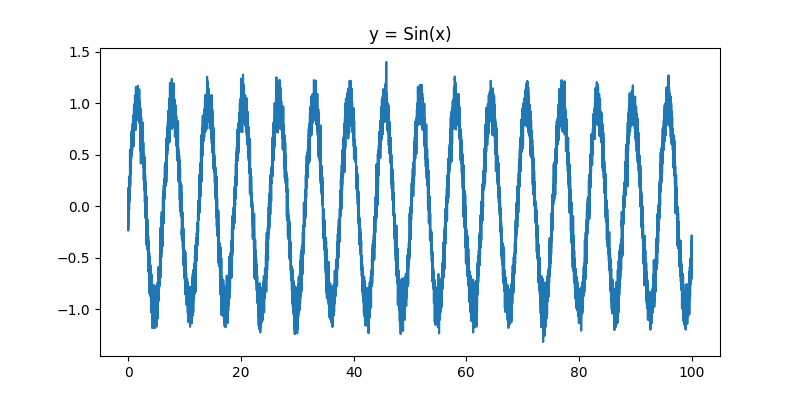

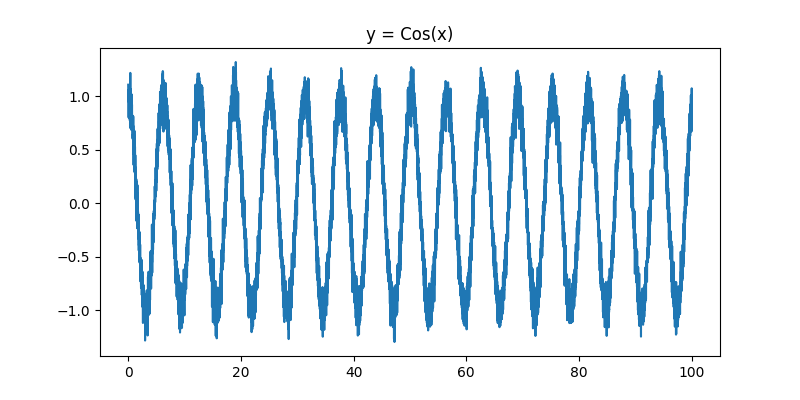

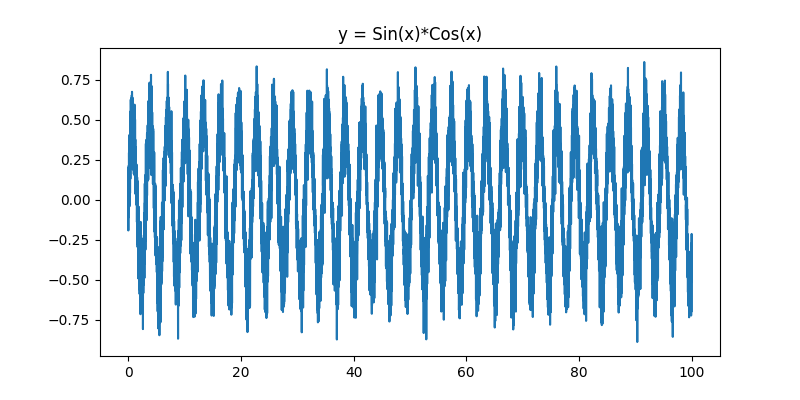

In [55]:
hp.Plt(x,y_sin).fig_size(8,4).plt_show(label = 'Sin(x)')
hp.Plt(x,y_cos).fig_size(8,4).plt_show(label = 'Cos(x)')
hp.Plt(x,y_sincos).fig_size(8,4).plt_show(label = 'Sin(x)*Cos(x)')

In [152]:
# 使用dataset 和dataloader 方便
batch = 10
T_seq = 20
# dataloader batch = batch*T_seq

In [173]:

data_np_features = data.values
data_np_labels = data_np_features[1:,:]
data_np = np.hstack((data_np_features[:-1,:],data_np_labels))#根据时间序列，生成包含label的完整data

data_sampler = hp.Sampler(data_np,batch_size = batch) # batch 补 0
data_transformed = data_sampler.gene_batch(T_seq = T_seq)#生成正确的时间时间序列数据，第一个bacth为（N,T_seq,ndim）,正好是二维Array的[:N*T_se,:]
data_tensor = torch.from_numpy(data_transformed) #转换为torch.tensor，与numpy 共享内存
data_tensor.shape

torch.Size([10010, 6])

In [212]:
iterator = hp.MyDataIterator(features = data_tensor[:,:3],labels = data_tensor[:,3:],batch_size =batch,T_seq = T_seq )
for data, labels in iterator:
    print(f'Feature size: {data.shape}, Label size: {labels.shape}')
    break

Feature size: torch.Size([10, 20, 3]), Label size: torch.Size([10, 20, 3])


## 2. 模型搭建Trucated Time LSTM

模型
$$
p(x_1,x_2,\cdots, x_T) = p(x_T | x_{T-1}, x_{T-2}\cdots,x_1 )p(x_{T-1} |x_{T-2}, x_{T-2}\cdots,x_1 )\cdots p(x_1|x_0)
$$

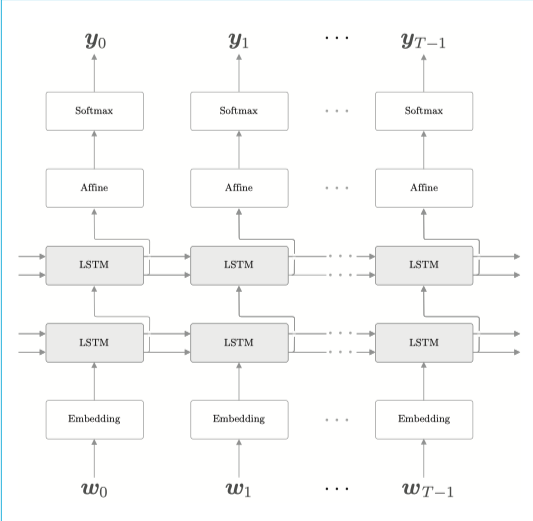
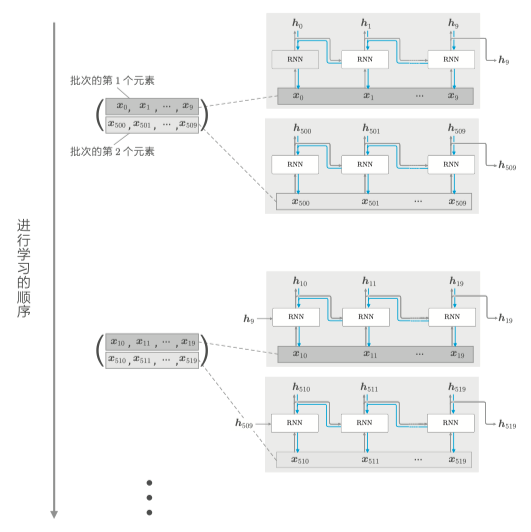

### 2.1. Code

In [180]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, stateful=False):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.stateful = stateful
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # 输入层到隐藏层的线性变换
            nn.Sigmoid(), 
            nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的线性变换
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out


In [200]:
model = LSTMModel(input_size=3, hidden_size=64, output_size=3, num_layers=2, stateful=True).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [201]:
# 定义损失函数
criterion = nn.MSELoss()
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [205]:
import time
start_time = time.time()
num_epochs = 100
# 在训练循环中使用模型
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_p_loss = 0.0
    num_batches = 0
    for batch_idx, (data,label) in enumerate(iterator):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs,label)
        # 累加 loss
        epoch_loss += loss.item()
        epoch_p_loss += loss.item()*label.numel()/(torch.norm(label, 'fro')**2)
        num_batches += 1
        
        loss.backward()
        optimizer.step()
    avg_epoch_loss = epoch_loss / num_batches
    avg_epoch_p_loss = epoch_p_loss / num_batches
    # 打印当前 epoch 的平均 loss
    elapsed_time = time.time() - start_time
    print(f'Epoch: {epoch+1}/{num_epochs}, MSE Loss: {avg_epoch_loss:.4f},PMSE Loss: {avg_epoch_p_loss:.4f},, Time Elapsed: {elapsed_time:.2f}s')

Epoch: 1/100, MSE Loss: 0.0123,PMSE Loss: 0.0319,, Time Elapsed: 0.15s
Epoch: 2/100, MSE Loss: 0.0123,PMSE Loss: 0.0318,, Time Elapsed: 0.24s
Epoch: 3/100, MSE Loss: 0.0123,PMSE Loss: 0.0320,, Time Elapsed: 0.33s
Epoch: 4/100, MSE Loss: 0.0125,PMSE Loss: 0.0323,, Time Elapsed: 0.42s
Epoch: 5/100, MSE Loss: 0.0124,PMSE Loss: 0.0320,, Time Elapsed: 0.51s
Epoch: 6/100, MSE Loss: 0.0124,PMSE Loss: 0.0321,, Time Elapsed: 0.60s
Epoch: 7/100, MSE Loss: 0.0123,PMSE Loss: 0.0319,, Time Elapsed: 0.69s
Epoch: 8/100, MSE Loss: 0.0125,PMSE Loss: 0.0323,, Time Elapsed: 0.79s
Epoch: 9/100, MSE Loss: 0.0124,PMSE Loss: 0.0321,, Time Elapsed: 0.88s
Epoch: 10/100, MSE Loss: 0.0123,PMSE Loss: 0.0319,, Time Elapsed: 0.97s
Epoch: 11/100, MSE Loss: 0.0123,PMSE Loss: 0.0320,, Time Elapsed: 1.06s
Epoch: 12/100, MSE Loss: 0.0123,PMSE Loss: 0.0319,, Time Elapsed: 1.15s
Epoch: 13/100, MSE Loss: 0.0123,PMSE Loss: 0.0319,, Time Elapsed: 1.24s
Epoch: 14/100, MSE Loss: 0.0123,PMSE Loss: 0.0317,, Time Elapsed: 1.33s
E

#### 2.1.1 Trian

#### 2.1.2 Test

#### 2.1.3 Plot

## 3. Other

In [53]:
import torch
import torch.nn as nn

# 创建一个 LSTM 模型
input_size = 6
hidden_size = 64
num_layers = 2

lstm = nn.LSTM(input_size, hidden_size, num_layers)

# 获取 LSTM 层的内部参数
for name, param in lstm.named_parameters():
    print(name, param.shape)  # 打印参数名称和形状
    if 'weight' in name:
        print(param)  

weight_ih_l0 torch.Size([256, 6])
Parameter containing:
tensor([[ 0.0190,  0.0466,  0.0939, -0.1031, -0.0823, -0.0815],
        [-0.1227,  0.1120, -0.0202,  0.0612, -0.0999,  0.0019],
        [ 0.0784, -0.0855, -0.0059, -0.1212, -0.1186,  0.0731],
        ...,
        [ 0.1211, -0.1246,  0.0883, -0.0198, -0.0063, -0.1188],
        [ 0.0736, -0.0348, -0.0507, -0.0438, -0.0813, -0.0166],
        [ 0.0602,  0.0599,  0.0517, -0.0870, -0.1011,  0.0219]],
       requires_grad=True)
weight_hh_l0 torch.Size([256, 64])
Parameter containing:
tensor([[ 0.0712,  0.0581, -0.0472,  ..., -0.0971,  0.0308, -0.0876],
        [-0.0146, -0.0151, -0.0565,  ..., -0.0939, -0.0738, -0.1106],
        [ 0.0443,  0.0448, -0.0205,  ...,  0.0342,  0.0542,  0.0120],
        ...,
        [-0.0541, -0.1113,  0.0172,  ..., -0.0155, -0.0938, -0.0826],
        [ 0.0789,  0.0968,  0.0339,  ..., -0.0500, -0.1214,  0.0398],
        [-0.0329,  0.0444,  0.0413,  ..., -0.1051, -0.0540,  0.0395]],
       requires_grad=True)
b

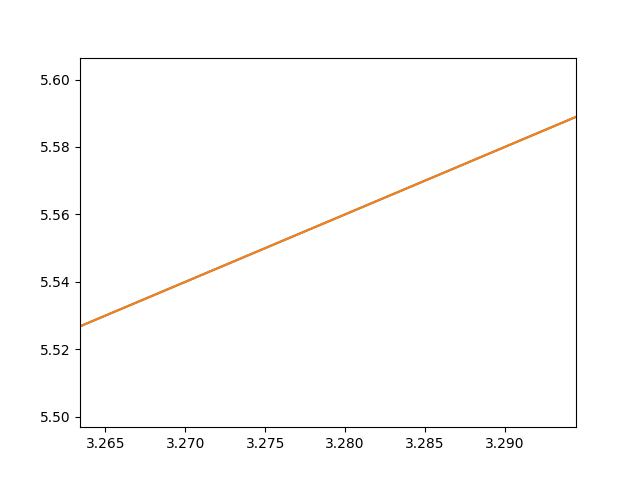

In [54]:

x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]
plt.plot(x, y)
plt.show()

In [ ]:
 哎查处